# Estimate sample phases using ML
- itk user-selection
- voxel clustering
- super voxel

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import itk
import itkwidgets
from itkwidgets import view, compare

In [3]:
from glob import glob
slices = glob('../images/concrete/*.tiff')
slices.sort()
concrete = itk.imread(slices)
print(itk.size(concrete))
print(itk.spacing(concrete))

itkSize3 ([2560, 2560, 31])
itkVectorD3 ([1, 1, 1])


In [4]:
new_spacing = [1, 1, 1] #change slice thickness
concrete.SetSpacing(new_spacing)

## ITK user selection

In [5]:
myViewer = view(concrete, mode='z') #slicing over z
myViewer

Viewer(geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itkImagePython.itkImageF…

In [6]:
#These are the coordinates of your crop
myViewer.roi_region()
#[789, 1102, 0], [700, 681, 31]

itkImageRegion3([738, 1160, 0], [664, 497, 31])

In [65]:
# User-selection is input for slicing np array
np_concrete = itk.array_from_image(concrete) 
roi = myViewer.roi_slice()
np_coreSample = np_concrete[roi]
#view(np_coreSample, annotations=False, ui_collapsed=True)

In [66]:
np_coreSample.shape

(31, 498, 665)

In [67]:
coreSample = itk.GetImageFromArray(np.ascontiguousarray(np_coreSample))
coreSample = itk.median_image_filter(coreSample)
view(coreSample)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageF3; proxy o…

## Voxel clustering

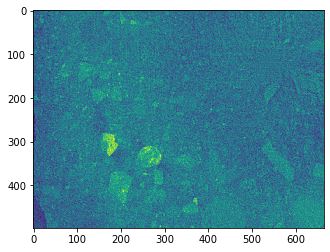

In [68]:
from skimage import img_as_ubyte
#np_coreSample = np_coreSample[:,::2,::2] #downsample for quick testing
np_coreSample = (np_coreSample-np.min(np_coreSample)) / np.max((np_coreSample-np.min(np_coreSample))) * 255
plt.imshow(np_coreSample[1,:,:])
#view(np_coreSample)

In [69]:
from sklearn import cluster
x,y,z = np_coreSample.shape
np_coreSampFlat = np_coreSample.reshape(x,y*z)
np_coreSampFlat.shape

(31, 331170)

In [70]:
numberOfClusters = 3
kmeans_cluster = cluster.KMeans(n_clusters=numberOfClusters)
kmeans_cluster.fit(np_coreSampFlat)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

In [71]:
img_labels = cluster_centers[cluster_labels].reshape(x, y, z)

In [72]:
img_labels.shape

(31, 498, 665)

In [74]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

middle = x//2

def mySlicer(s=middle):
    img = img_labels[s,:,:]
    plt.imshow(img)
    
interact(mySlicer, s=widgets.IntSlider(min=1,max=x,step=1,value=middle));    

interactive(children=(IntSlider(value=15, description='s', max=31, min=1), Output()), _dom_classes=('widget-in…

In [60]:
np.max(img_labels)

140.33333333333334

In [75]:
view(img_labels,annotations=False, ui_collapsed=True,mode='z')

Viewer(annotations=False, geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itkIm…

In [25]:
interpolator = itk.BSplineInterpolateImageFunction.New(np_coreSample, spline_order=3)
mesh = itk.cuberille_image_to_mesh_filter(np_coreSample,
                                          interpolator=interpolator,
                                          iso_surface_value=thresholded,
                                          project_vertices_to_iso_surface=True,
                                          project_vertex_surface_distance_threshold=0.5)
view(geometries=mesh)

TemplateTypeError: itk.BSplineInterpolateImageFunction is not wrapped for input type `None`.

To limit the size of the package, only a limited number of
types are available in ITK Python. To print the supported
types, run the following command in your python environment:

    itk.BSplineInterpolateImageFunction.GetTypes()

Possible solutions:
* If you are an application user:
** Convert your input image into a supported format (see below).
** Contact developer to report the issue.
* If you are an application developer, force input images to be
loaded in a supported pixel type.

    e.g.: instance = itk.BSplineInterpolateImageFunction[itk.Image[itk.SS,2], itk.D, itk.SS].New(my_input)

* (Advanced) If you are an application developer, build ITK Python yourself and
turned to `ON` the corresponding CMake option to wrap the pixel type or image
dimension you need. When configuring ITK with CMake, you can set
`ITK_WRAP_${type}` (replace ${type} with appropriate pixel type such as
`double`). If you need to support images with 4 or 5 dimensions, you can add
these dimensions to the list of dimensions in the CMake variable
`ITK_WRAP_IMAGE_DIMS`.

Supported input types:

itk.Image[itk.SS,2]
itk.Image[itk.UC,2]
itk.Image[itk.US,2]
itk.Image[itk.F,2]
itk.Image[itk.SS,3]
itk.Image[itk.UC,3]
itk.Image[itk.US,3]
itk.Image[itk.F,3]


## Segment phases
- matrix, aggregate and interstitial space (pores)